## What's the probability that the runout of a potential landslide slope reaches a downslope bridge?

###                        Run MassWastingRunout with a user defined unstable slope

In [1]:
# setup
import os

## import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## import necessary landlab components
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, LandslideProbability, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                                FlowDirectorDINF, 
                                FlowDirectorMFD, 
                                FlowDirectorSteepest)

from landlab.components.mass_wasting_router import MassWastingRunout

## import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from landlab import imshow_grid_at_node

## import functions
from landlab.io.esri_ascii import write_esri_ascii
from landlab.io import read_esri_ascii
from landlab.io.netcdf import read_netcdf

from landlab.components import ChannelProfiler, FlowAccumulator, DepressionFinderAndRouter


from landlab.components.mass_wasting_router.landslide_mapper import LandslideMapper as LM
from landlab.components.mass_wasting_router import MassWastingRunout 


### import other custom plotting code and functions

In [2]:
os.chdir('C:/Users/keckje/Documents/GitHub/code/landlab/LandlabTools')
import LandlabTools as LLT
os.chdir('C:/Users/keckje/Documents/GitHub/landlab/landlab/components/mass_wasting_router')
from mwru_calibrator import (MWRu_calibrator,
                                profile_distance,
                                profile_plot,
                                view_profile_nodes)
os.chdir('C:/Users/keckje/Documents/GitHub/code/preevents/paper2/')
import MassWastingRunoutEvaluationFunctions as MWF
os.chdir('C:/Users/keckje/Documents/GitHub/landlab/landlab/components/mass_wasting_router')
from mass_wasting_runout_probability import (MassWastingRunoutProbability,
                                generate_cdf)

### import gis generated inputs (DEM) and set notebook controls

In [3]:
svfig = 0 
svnm = 'PtUnSlp_200_'
hf = 30
wf = 15


# MWR controls
qsc_constraint = True
method = "both"
routing_surface = "topographic__elevation"
settle_deposit = False
deposition_rule = "critical_slope"
deposit_style = 'downslope_deposit_sc10'
effective_qsi = True
qsi_max = 10
g_erosion = True


# GIS generated inputs
bdfdem = 'dem_mask.asc' # before debris flow dem
bdfdem_hs = 'dem3fths_nd27.asc' # before debris flow dem hs
potunslp = 'pot_unst_slpv2.asc'
    


# MWRP
own = False # use parameter values from same site?
ni = 10
method = 'variable_size_landslide'


mdir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/KunamasktCreek/output/p2_final/MWRu_probability/'

# GIS input file location
dem_dir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/KunamasktCreek/input/'
# file location where output will be saved
mdir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/KunamasktCreek/output/p2_final/MWRu_probability/'
pot_dir = dem_dir + 'pot_unst_slp/'

### load calibration results and define inputs for MassWastingRunout

C:\Users\keckje\Documents\GitHub\code\preevents\paper2\MassWastingRunoutEvaluationFunctions.py:1087: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = ax.contour(grid_x,grid_y,grid_z1,np.linspace(np.nanmin(grid_z1),np.nanmax(grid_z1),cntrs), colors='k', linewidth = 0.5)
C:\Users\keckje\Documents\GitHub\code\preevents\paper2\MassWastingRunoutEvaluationFunctions.py:1113: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = ax.contour(grid_x,grid_y,grid_z1,np.linspace(np.nanmin(grid_z1),np.nanmax(grid_z1),cntrs), colors='k', linewidth = 0.5)


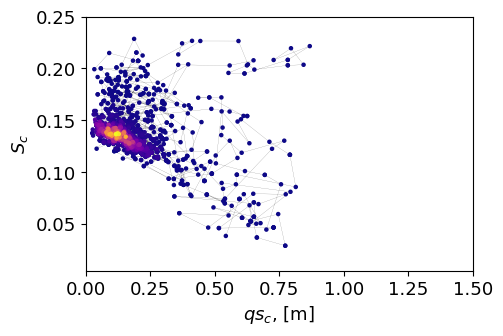

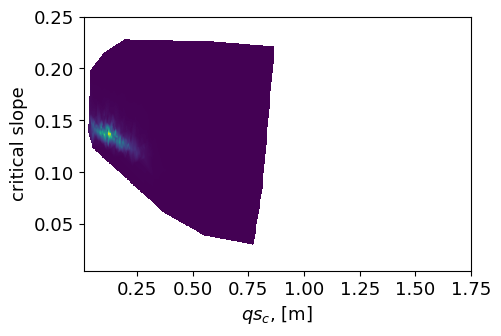

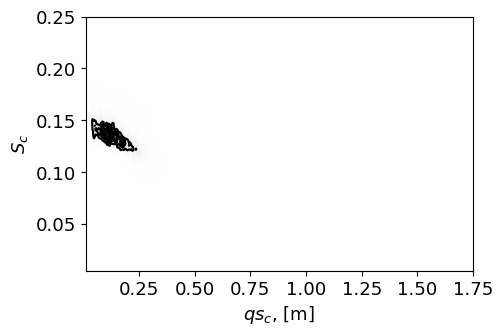

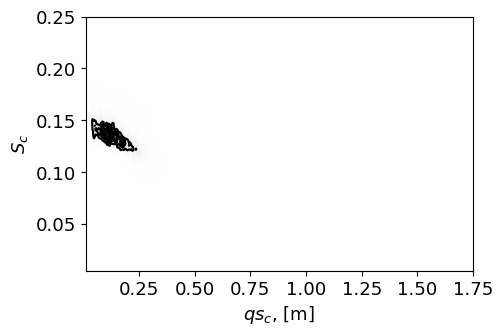

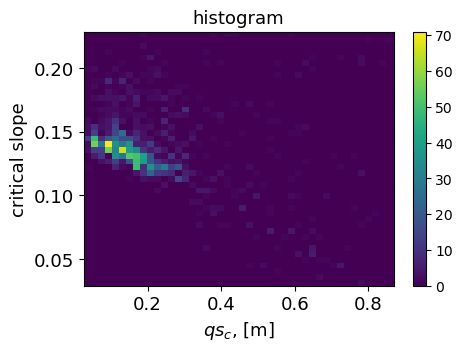

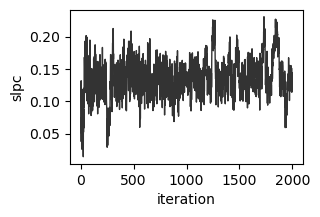

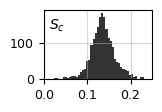

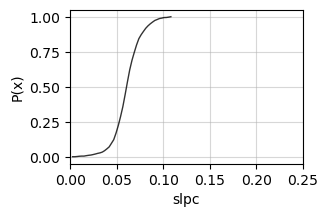

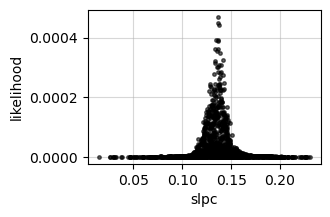

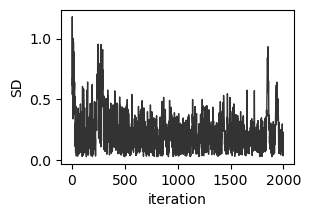

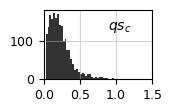

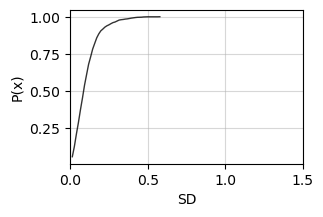

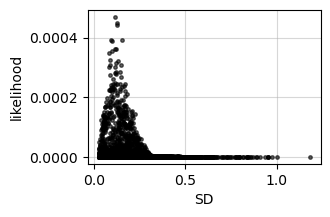

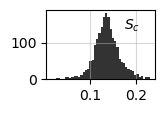

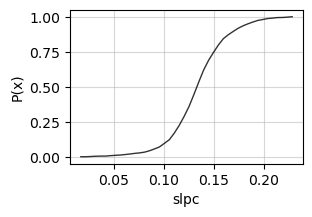

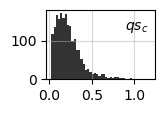

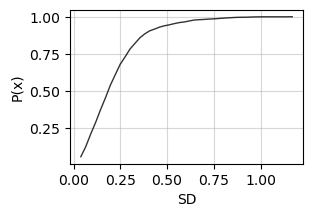

In [4]:
#%% calibration results
csvnm = 'K_2000_ns_n_mcmc.csv'

# location of calibration output
mdir = 'D:/UW_PhD/PreeventsProject/Paper_2_MWR/RunoutValidation/KunamasktCreek/output/p2_final/MCMC_v1/'

results, best, sum_dict, params, mw_dict = MWF.calibration_results(mdir, csvnm, aspect = 'auto', fs = 13, cntrs = 8, figsize = (5,3.3),
                        save = True, svnm = svnm, wdir = mdir, labloc = [[0.05,0.75], [0.75,0.75]])   

#%% define parameter_cdf
q,vals = generate_cdf(results,'slpc')
parameter_cdf = {'slpc':[q,vals]}
q,vals = generate_cdf(results,'SD')
parameter_cdf['SD'] = [q,vals]



release_dict = {'number of pulses':[1], 'iteration delay':[1] }


### load topography, hillshade, soilthickness and grainsize fields

In [5]:
# load existing landscape dem
mg, z = read_esri_ascii(dem_dir+bdfdem, name='topographic__elevation')
sz = z.shape 

# hillshade for plots
mg.at_node['hillshade'] = mg.calc_hillshade_at_node(elevs=z, alt=30., az=210.)

# set boundary conditions
mg.status_at_node[np.isclose(z, -9999.)] = mg.BC_NODE_IS_CLOSED
mg.set_watershed_boundary_condition(z) #finds lowest point in dem and sets it as an open node

# soil depth
(gt7, depth) = read_esri_ascii(dem_dir+'soild_nomask.asc', name='soil__thickness') 
mg.add_field('node', 'soil__thickness',depth)


# # give particale diameter, north of 5288000 is coarse sandstone
# mg.at_node['particle__diameter'] = np.ones(len(depth))*l_D
# mg.at_node['particle__diameter'][mg.node_y>5288000] = u_D


# DEM metrics, compute with landlab functions

# compute slope, flow direction and fields
slope, aspect = mg.calculate_slope_aspect_at_nodes_burrough(vals='topographic__elevation',)

# Run FlowAccumulator, creates drainage area, reciever and slope fields
fr = FlowAccumulator(mg,'topographic__elevation',flow_director='D8')
fr.run_one_step()

# fill sinks to see if Flow Accumulator works better
sfb = SinkFillerBarnes(mg,'topographic__elevation', method='D8',fill_flat = False, 
                       ignore_overfill = False)
sfb.run_one_step()


df_4 = DepressionFinderAndRouter(mg)
df_4.map_depressions()


# run flow director, add slope and receiving node fields
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')


# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'slope')
# fd = FlowDirectorDINF(mg)

# fd = FlowDirectorD8(mg)
fd.run_one_step()


# compute specific contributing area
SCA = mg.at_node['drainage_area']/mg.dx

# add particle diameter
if g_erosion:
    mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*mw_dict['effective particle diameter']

### view topography

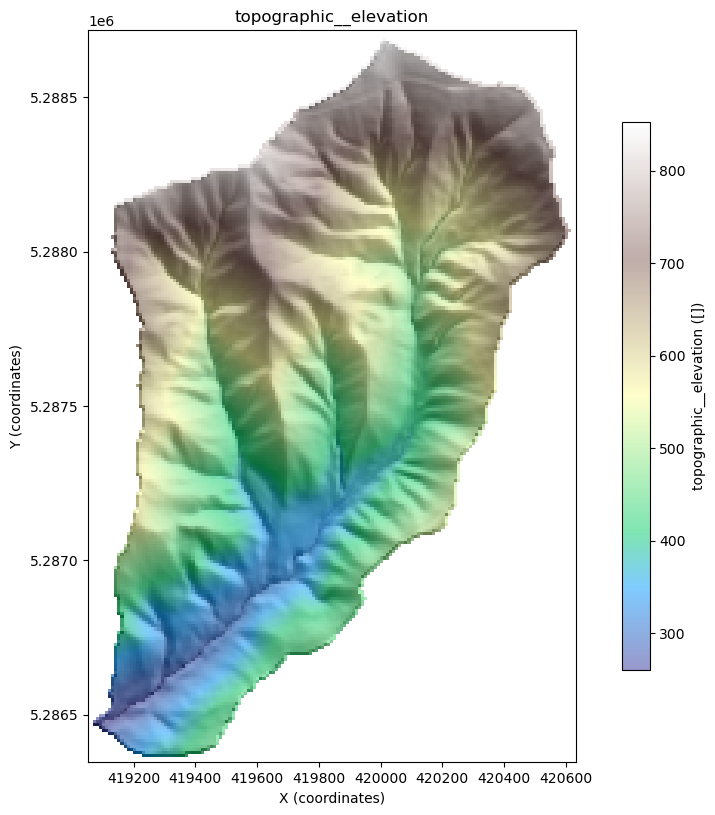

In [6]:
LLT.plot_node_field_with_shaded_dem(mg,field = 'topographic__elevation', fontsize = 10)

### now add the potentially unstable slope polygon

In [7]:
# mass wasting id
_, mw1 = read_esri_ascii(pot_dir+potunslp, name='mass__wasting_id')
mg.add_field('node', 'mass__wasting_id',mw1.astype(int))

array([-9999, -9999, -9999, ..., -9999, -9999, -9999])

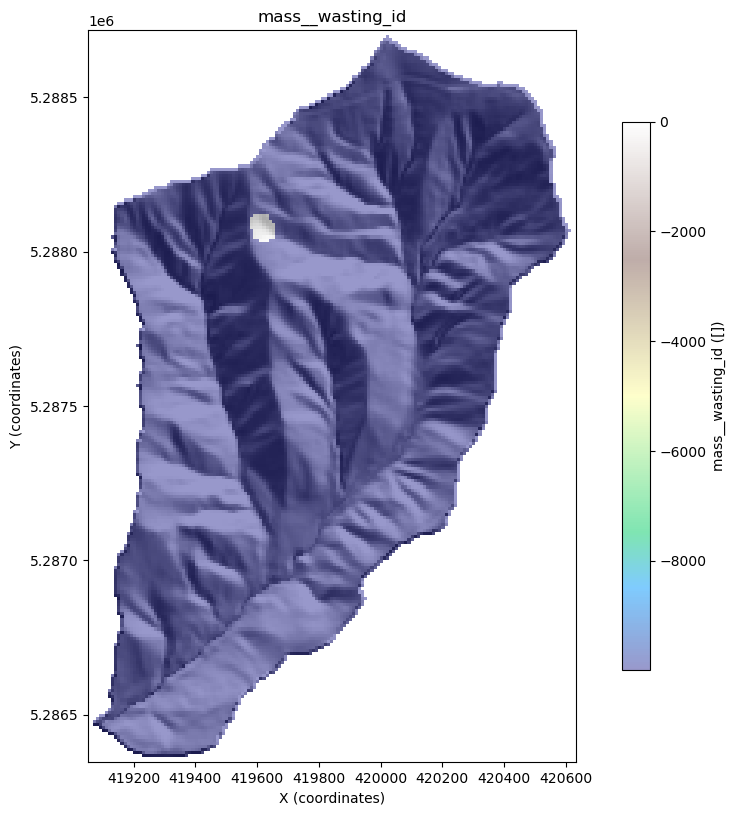

In [8]:
LLT.plot_node_field_with_shaded_dem(mg,field = 'mass__wasting_id', fontsize = 10)

### instantiate MassWastingRunout!!!!

In [9]:
DebrisFlows = MassWastingRunout(mg,release_dict,mw_dict, save = False,
                                veg_factor = 1,
                                dist_to_full_flux_constraint = 0,
                                routing_surface = routing_surface,
                                settle_deposit = settle_deposit,
                                deposition_rule = deposition_rule,
                                deposit_style = deposit_style,
                                effective_qsi = effective_qsi)

 running with spatially variable Dp 


### instantiate MassWastingRunoutProbability (MWRP) !!!!

In [10]:
MWRP = MassWastingRunoutProbability(grid = mg,
                                    MWR = DebrisFlows,
                                    parameter_cdf = parameter_cdf,
                                    number_iterations = ni,
                                    plot = False,
                                    method = method, 
                                    )

### Run MWRP

In [11]:
MWRP.run_one_step()

sending them down the hill, iteration 0
20
40
60
80
100
120
0
sending them down the hill, iteration 1
20
40
60
80
100
120
140
1
sending them down the hill, iteration 2
20
40
60
80
100
120
140
2
sending them down the hill, iteration 3
20
40
60
80
100
120
3
sending them down the hill, iteration 4
4
sending them down the hill, iteration 5
20
40
60
80
100
120
140
160
180
5
sending them down the hill, iteration 6
20
40
60
80
100
120
140
160
6
sending them down the hill, iteration 7
20
40
60
80
100
120
140
160
7
sending them down the hill, iteration 8
20
40
60
80
100
120
8
sending them down the hill, iteration 9
9


### lets took a look at the likelihood that the runout reached the bridge

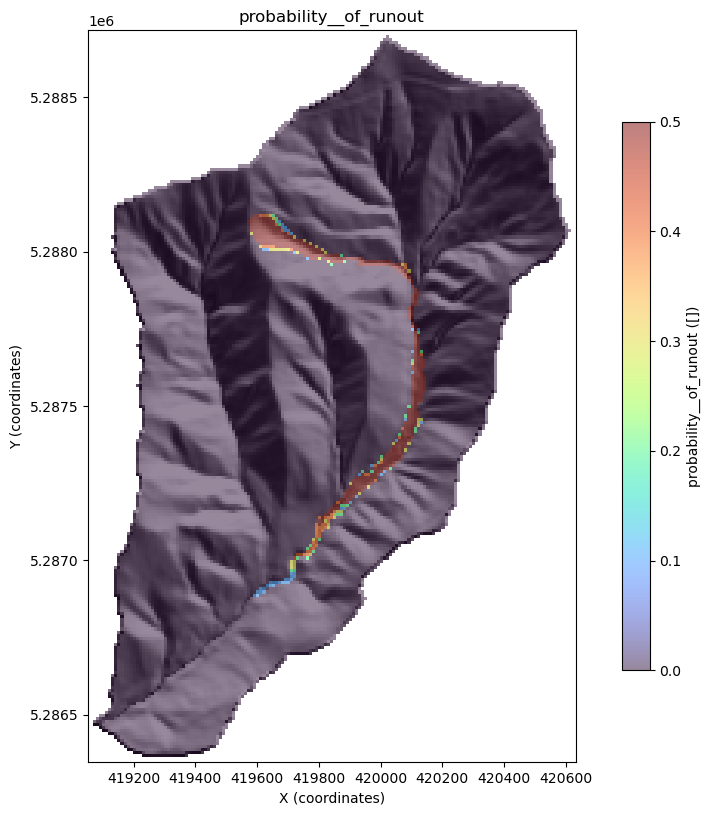

In [12]:
LLT.plot_node_field_with_shaded_dem(mg,field = 'probability__of_runout',fontsize = 10, cmap = 'turbo')
plt.clim(0,0.5)